In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

In [28]:
df = pd.read_csv("data/processed/happiness_model.csv")  

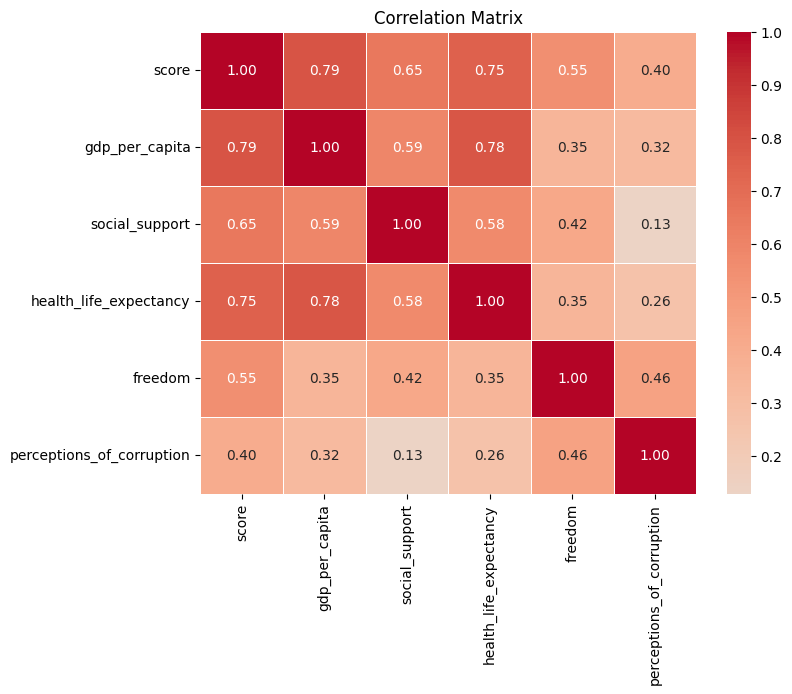

In [29]:
plt.figure(figsize=(8,6))
corr_matrix = df[[
    "score",
    "gdp_per_capita",
    "social_support",
    "health_life_expectancy",
    "freedom",
    "perceptions_of_corruption"
]].corr()

sns.heatmap(
    corr_matrix, annot=True, cmap='coolwarm', center=0,
    linewidths=0.5, fmt=".2f"
)
plt.title("Correlation Matrix")
plt.show()


In [30]:
X = df[[
    "gdp_per_capita",
    "social_support",
    "health_life_expectancy",
    "freedom",
    "perceptions_of_corruption"
]]
y = df["score"]

print(f"Observaciones totales: {len(df)}")

Observaciones totales: 771


In [31]:
X_ols = sm.add_constant(X)
modelo = sm.OLS(y, X_ols).fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     489.0
Date:                Fri, 07 Nov 2025   Prob (F-statistic):          2.17e-235
Time:                        17:50:09   Log-Likelihood:                -638.32
No. Observations:                 771   AIC:                             1289.
Df Residuals:                     765   BIC:                             1317.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

### Supuestos

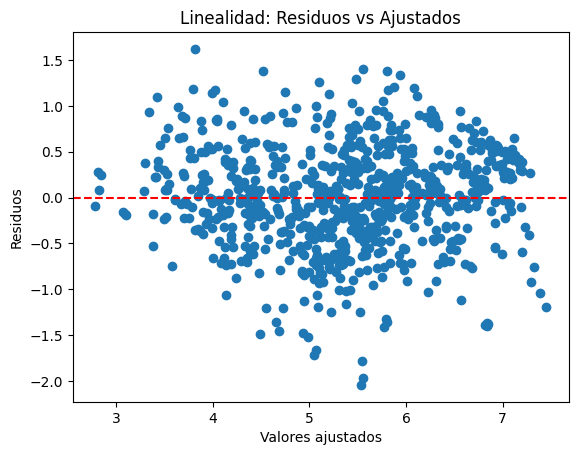

In [32]:
plt.scatter(modelo.fittedvalues, modelo.resid)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Valores ajustados")
plt.ylabel("Residuos")
plt.title("Linealidad: Residuos vs Ajustados")
plt.show()

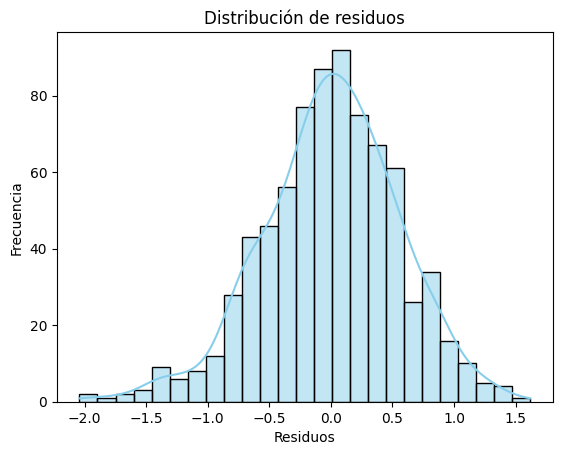

In [33]:
sns.histplot(modelo.resid, kde=True, color='skyblue')
plt.title("Distribución de residuos")
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.show()

In [34]:
shapiro_test = stats.shapiro(modelo.resid)
ad_test = normal_ad(modelo.resid)
print(f"Shapiro-Wilk: p={shapiro_test.pvalue:.4f}")
print(f"Anderson-Darling: p={ad_test[1]:.4f}")

Shapiro-Wilk: p=0.0012
Anderson-Darling: p=0.0097


In [35]:
vif = pd.DataFrame()
vif["Variable"] = X_ols.columns
vif["VIF"] = [variance_inflation_factor(X_ols.values, i) for i in range(X_ols.shape[1])]
print(vif)

                    Variable        VIF
0                      const  14.050786
1             gdp_per_capita   2.921825
2             social_support   1.822952
3     health_life_expectancy   2.747498
4                    freedom   1.529185
5  perceptions_of_corruption   1.376861


### Model training

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
n, k = X_test.shape

results = []

def model_eval(nombre, y_test, y_pred, n, k):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    aic = n * np.log(mse) + 2 * (k + 1)
    bic = n * np.log(mse) + (k + 1) * np.log(n)
    return [nombre, r2, rmse, mape, aic, bic]

ols = LinearRegression().fit(X_train, y_train)
y_pred_ols = ols.predict(X_test)
results.append(model_eval("OLS", y_test, y_pred_ols, n, k))

ridge = RidgeCV(alphas=np.arange(0.01, 1, 0.05), cv=5).fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
results.append(model_eval("Ridge", y_test, y_pred_ridge, n, k))

lasso = LassoCV(alphas=np.arange(0.001, 1, 0.01), cv=5, n_jobs=-1, random_state=42).fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
results.append(model_eval("Lasso", y_test, y_pred_lasso, n, k))

elastic = ElasticNetCV(alphas=np.arange(0.001, 1, 0.01),
                       l1_ratio=np.arange(0.1, 1, 0.1),
                       cv=5, n_jobs=-1, random_state=42).fit(X_train, y_train)
y_pred_elastic = elastic.predict(X_test)
results.append(model_eval("ElasticNet", y_test, y_pred_elastic, n, k))

df_results = pd.DataFrame(results, columns=["Modelo", "R²", "RMSE", "MAPE", "AIC", "BIC"])
df_results = df_results.round(4).sort_values("R²", ascending=False).reset_index(drop=True)
display(df_results)

,Modelo,R²,RMSE,MAPE,AIC,BIC
0,Ridge,0.7667,0.5511,0.0859,-264.4631,-243.7827
1,ElasticNet,0.7665,0.5514,0.0859,-264.2032,-243.5228
2,OLS,0.7660,0.5520,0.0859,-263.7187,-243.0383
3,Lasso,0.7656,0.5524,0.0861,-263.3534,-242.6730


In [37]:
best_model_name = df_results.loc[df_results["R²"].idxmax(), "Modelo"]
print(f"Mejor modelo: {best_model_name}")

if best_model_name == "OLS":
    best_model = ols
elif best_model_name == "Ridge":
    best_model = ridge
elif best_model_name == "Lasso":
    best_model = lasso
else:
    best_model = elastic

joblib.dump(best_model, f"models/Best_{best_model_name}_Model.pkl")
print(f"Modelo guardado como: Best_{best_model_name}_Model.pkl")

Mejor modelo: Ridge
Modelo guardado como: Best_Ridge_Model.pkl


In [38]:
y_pred_final = best_model.predict(X)
mse = mean_squared_error(y, y_pred_final)
r2 = r2_score(y, y_pred_final)
print(f"Modelo final: {best_model_name} — R²={r2:.4f} | RMSE={np.sqrt(mse):.4f}")

Modelo final: Ridge — R²=0.7612 | RMSE=0.5543
